# Variational Bayesian Last Layer (VBLL) Regression

In [83]:
%pip install lightning-uq-box

Note: you may need to restart the kernel to use updated packages.


In [109]:
import os
import tempfile
from functools import partial

import numpy as np
import torch
import torch.nn as nn
from lightning import LightningDataModule, Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from torch.utils.data import DataLoader, Dataset

from lightning_uq_box.datamodules import ToyDUE
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import VBLLRegression
from lightning_uq_box.viz_utils import (
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
# temporary directory for saving
my_temp_dir = tempfile.mkdtemp()

seed_everything(42)

Seed set to 42


42

## Datamodule

In [86]:
class SimpleFnDataset(Dataset):
    """The simple function used in DUE/SNGP 1-d regression experiments.
    Based on the implementation presented in:
    https://github.com/y0ast/DUE/blob/main/toy_regression.ipynb
    """

    def __init__(self, num_samples):
        self.num_samples = int(num_samples)
        self.X, self.Y = self.get_data()

    def get_data(self, noise=0.05, seed=2):
        np.random.seed(seed)

        self.W = np.random.randn(30, 1)
        self.b = np.random.rand(30, 1) * 2 * np.pi

        x = 5 * np.sign(np.random.randn(self.num_samples)) + np.random.randn(
            self.num_samples
        ).clip(-2, 2)
        y = np.cos(self.W * x + self.b).sum(0) / 5.0 + noise * np.random.randn(
            self.num_samples
        )
        return torch.tensor(x[..., None]).float() / 10, torch.tensor(
            y[..., None]
        ).float()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


class SimpleFNDatamodule(LightningDataModule):
    def __init__(self, batch_size, num_samples):
        self.batch_size = batch_size
        self.num_samples = num_samples
        self.train_ds = SimpleFnDataset(self.num_samples)
        self.X_train, self.y_train = self.train_ds.X, self.train_ds.Y

        num_test_samples = 1000
        self.W = torch.randn(num_samples, 1)
        self.b = torch.rand(num_samples, 1) * 2 * np.pi

        self.X_test = torch.linspace(-1.5, 1.5, num_test_samples).view(-1, 1).float()
        self.y_test = torch.cos(self.W * self.X_test + self.b).sum(0) / 5.0

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

In [87]:
datamodule = ToyDUE(batch_size=32, n_samples=128, normalize=True)
# datamodule = SimpleFNDatamodule(batch_size=32, num_samples=128)
datamodule.__dict__.keys()
X_train, y_train, X_test, y_test, train_loader = (
    datamodule.X_train,
    datamodule.y_train,
    datamodule.X_test,
    datamodule.y_test,
    datamodule.train_dataloader(),
)

In [88]:
X_train.shape

torch.Size([128, 1])

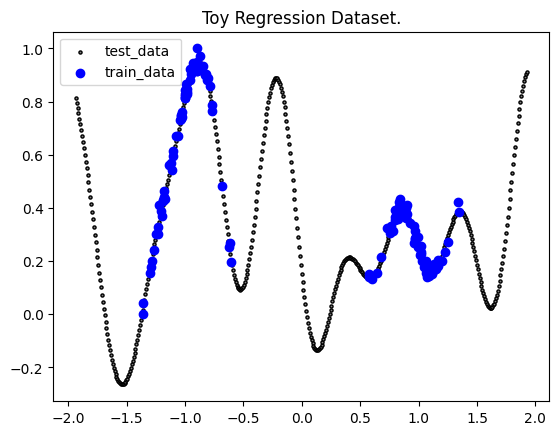

In [89]:
fig = plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

We define a backbone model, to which the VBLL layer will be attached.

In [110]:
# TODO write down their exact model for testing
network = MLP(n_inputs=1, n_hidden=[64, 64], n_outputs=64, activation_fn=nn.ELU())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
  )
)

In [111]:
vbll_model = VBLLRegression(
    model=network,
    num_targets=1,  # single regression targets
    regularization_weight=(1 / X_train.shape[0]) * 50,
    optimizer=partial(torch.optim.Adam, lr=3e-3),
    prior_scale=1.0,
    wishart_scale=0.1,
)

## Trainer

In [112]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=1000,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=True,
    limit_val_batches=0.0,  # no validation runs
    default_root_dir=my_temp_dir,
    gradient_clip_val=1.0,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


In [113]:
trainer.fit(vbll_model, datamodule)


  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 12.7 K
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
12.7 K    Trainable params
1         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 999: 100%|██████████| 4/4 [00:00<00:00, 48.26it/s, v_num=3] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 4/4 [00:00<00:00, 45.86it/s, v_num=3]


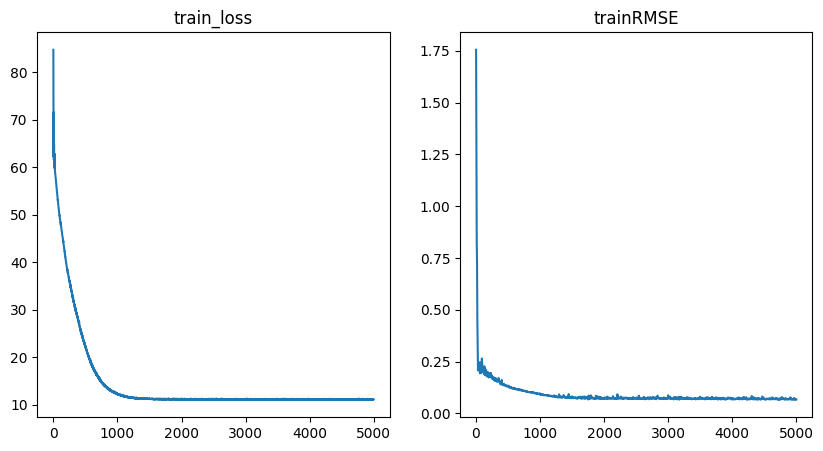

In [107]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

## Prediction

In [95]:
preds = vbll_model.predict_step(X_test)

In [96]:
preds["pred_uct"]

tensor([[0.1058],
        [0.1053],
        [0.1048],
        [0.1043],
        [0.1038],
        [0.1032],
        [0.1027],
        [0.1023],
        [0.1018],
        [0.1013],
        [0.1008],
        [0.1003],
        [0.0999],
        [0.0994],
        [0.0990],
        [0.0985],
        [0.0981],
        [0.0977],
        [0.0973],
        [0.0968],
        [0.0964],
        [0.0960],
        [0.0956],
        [0.0952],
        [0.0949],
        [0.0945],
        [0.0941],
        [0.0937],
        [0.0934],
        [0.0930],
        [0.0927],
        [0.0924],
        [0.0920],
        [0.0917],
        [0.0914],
        [0.0911],
        [0.0908],
        [0.0905],
        [0.0902],
        [0.0899],
        [0.0896],
        [0.0894],
        [0.0891],
        [0.0889],
        [0.0886],
        [0.0884],
        [0.0882],
        [0.0879],
        [0.0877],
        [0.0875],
        [0.0873],
        [0.0871],
        [0.0870],
        [0.0868],
        [0.0866],
        [0

## Evaluate Predictions

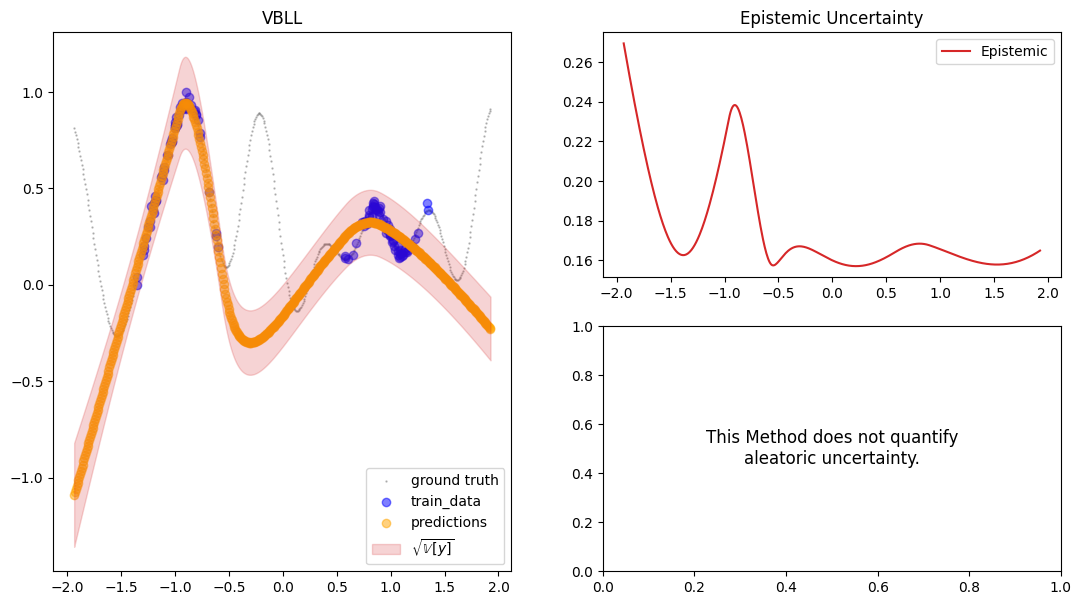

In [122]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"].squeeze(-1),
    epistemic=preds["pred_uct"].squeeze(-1),
    show_bands=False,
    title="VBLL",
)